In [1]:
import warnings
warnings.filterwarnings("ignore")

import pytorch_lightning as pl
from omegaconf import OmegaConf
import torch
from dabs.src.systems import viewmaker_original
from tqdm import tqdm
import os 
from torchvision.utils import save_image
import torch.nn.functional as F
import numpy as np
import torchattacks as ta
import pandas as pd

In [70]:
dataset = 'birds'

if dataset == 'traffic':
    conf_yaml = '/workspace/dabs/conf/traffic.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/traffic_sign_small.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/traffic_model.yaml'
    ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt'
    systemClass = viewmaker_original.TrafficViewMaker
    batch_size = 32
    

elif dataset == 'lfw':
    conf_yaml = '/workspace/dabs/conf/ceva.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/lfw_112.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/ceva_model.yaml'
    ckpt = '/workspace/dabs/exp/models/traffic_budget_budget=0.005/model.ckpt'
    systemClass = viewmaker_original.CevaViewmakerSystem
    batch_size = 32
    
    root = '/workspace/dabs/data/adv_data/lfw/date/experiment_name/'+part

    label_counters ={}

    def save_func(original,views_similarities,label, class_names):
        path = os.path.join(root, class_names[label])
        if not os.path.exists(path):
            os.makedirs(path)

        if label in label_counters:
            label_counters[label] += 1
        else:
            label_counters[label] = 0

        save_image(original,f'{path}/{label_counters[label]:04d}_original.jpg')

        for j in range(len(views_similarities)):
            unnormalized_view, similarity = views_similarities[j]
            save_image(unnormalized_view,f'{path}/{label_counters[label]:04d}_view_{j+1}_sim_{similarity:.3f}.jpg')

elif dataset == 'birds':
    conf_yaml = '/workspace/dabs/conf/birds.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/cu_birds_small.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/birds_model.yaml'
    ckpt = '/workspace/dabs/exp/models/birds_dyn_sweep_budget=0.025/model.ckpt'
    systemClass = viewmaker_original.BirdsViewMaker
    batch_size = 12
    
elif dataset == 'mnist':
    conf_yaml = '/workspace/dabs/conf/mnist.yaml'
    conf_dataset_yaml = '/workspace/dabs/conf/dataset/mnist.yaml'
    conf_model_yaml = '/workspace/dabs/conf/model/mnist_model.yaml'
    ckpt = '/workspace/dabs/exp/models/mnist_sweep_2023-01-21_06:32:36/model.ckpt'
    systemClass = viewmaker_original.MNISTViewMaker
    batch_size = 256
    


In [71]:
print('loading config...')
config = OmegaConf.load(conf_yaml)
config.dataset = OmegaConf.load(conf_dataset_yaml)
config.model = OmegaConf.load(conf_model_yaml)
config.dataset.batch_size = batch_size
config.debug = True
pl.seed_everything(config.trainer.seed)

print('loading VM...')
system = torch.load(ckpt)
system.cuda()
system.eval()




Global seed set to 0


loading config...
loading VM...


BirdsViewMaker(
  (model): BirdsModel(
    (embed_modules): ModuleList()
    (birds_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [72]:
from types import MethodType
if dataset == 'traffic':
    def forward_original(self, x):
        # transform the input
        x = self.stn(x)

        # Perform forward pass
        x = self.bn1(F.max_pool2d(F.leaky_relu(self.conv1(x)),2))
        x = self.conv_drop(x)
        x = self.bn2(F.max_pool2d(F.leaky_relu(self.conv2(x)),2))
        x = self.conv_drop(x)
        x = self.bn3(F.max_pool2d(F.leaky_relu(self.conv3(x)),2))
        x = self.conv_drop(x)
        x = x.view(-1, 250*2*2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    system.model.traffic_model.forward = MethodType(forward_original, system.model.traffic_model)
    threat_model  = system.model.traffic_model
    MEAN,STD = np.array([0.3337, 0.3064, 0.3171],dtype=np.float32), np.array([ 0.2672, 0.2564, 0.2629],dtype=np.float32)
    defense_path = '/workspace/gtsrb_pytorch/model_defended.pth' # FGSM e=0.005

elif dataset == 'birds':
    def new_forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return F.softmax(x, dim = -1)

    system.model.birds_model.forward = MethodType(new_forward, system.model.birds_model)
    threat_model  = system.model.birds_model
    MEAN = [0.483, 0.491, 0.424]
    STD  = [0.228, 0.224, 0.259]
    defense_path = '/workspace/cubirds/resnet18-adv.pt' # FGSM e=0.025

elif dataset == 'mnist':
    def new_forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        y = self.dropout2(x)
        x = self.fc2(y)
        output = F.log_softmax(x, dim=1)
        return output

    system.model.mnist_model.forward = MethodType(new_forward, system.model.mnist_model)
    threat_model  = system.model.mnist_model

    defense_path = '/workspace/MNIST/mnist_defense.pt' # FGSM e=0.3
    MEAN = [0.1307]
    STD  = [0.3081]
    

In [73]:
import copy
# defense = 'no'
defense = 'defended'
if defense == "defended":
    defended = copy.deepcopy(threat_model)
    defended.load_state_dict(torch.load(defense_path))
    defended.eval()
    test_model = defended
else:
    test_model = threat_model

RuntimeError: Error(s) in loading state_dict for ResNet:
	Unexpected key(s) in state_dict: "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer1.2.bn3.num_batches_tracked", "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.1.bn3.num_batches_tracked", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.2.bn3.num_batches_tracked", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer2.3.bn3.num_batches_tracked", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.0.bn3.num_batches_tracked", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.1.bn3.num_batches_tracked", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.2.bn3.num_batches_tracked", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.3.bn3.num_batches_tracked", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.4.bn3.num_batches_tracked", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer3.5.bn3.num_batches_tracked", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.0.bn3.num_batches_tracked", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.1.bn3.num_batches_tracked", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.bn1.num_batches_tracked", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.bn2.num_batches_tracked", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var", "layer4.2.bn3.num_batches_tracked", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.0.bn3.num_batches_tracked", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.1.bn3.num_batches_tracked". 
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for layer2.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for layer2.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for layer3.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for layer3.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for layer4.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer4.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for fc.weight: copying a param with shape torch.Size([200, 2048]) from checkpoint, the shape in current model is torch.Size([200, 512]).

In [66]:
run='vm'
pl.seed_everything(123654)


df_dict = {
    "label" : [],
    "pred" : [],
    "adv_pred": []
}
num_views = 3

loaders = [system.train_dataloader(), system.val_dataloader()]

if run=='vm':
    # VM
    for loader in loaders:
        for index , img , labels in tqdm(loader):
            with torch.no_grad():
                img = img.cuda()
                for i in range(num_views):
                    views1, _ = system.view(img, True)
                    pred = test_model(system.normalize(img)).argmax(1, keepdim = True)
                    adv_pred = test_model(views1).argmax(1, keepdim = True)

                    df_dict['label'].append(labels.unsqueeze(-1).cpu())
                    df_dict['pred'].append(pred.cpu())
                    df_dict['adv_pred'].append(adv_pred.cpu())

elif run=='adv':
    # FGSM
    num_views = 1
    atk = ta.FGSM(threat_model, eps=0.005)
    # atk = ta.PGD(threat_model, eps=0.035, alpha=0.035/8, steps=10)
    
    atk.set_normalization_used(mean=MEAN, std=STD)
    for loader in loaders:
        for index , img , labels in tqdm(loader):
            # with torch.no_grad():
            img = img.cuda()
            for i in range(num_views):
                # views1, _ = system.view(img, True)
                views1 = atk(system.normalize(img),labels)
                pred = test_model(system.normalize(img)).argmax(1, keepdim = True)
                adv_pred = test_model(views1).argmax(1, keepdim = True)

                df_dict['label'].append(labels.unsqueeze(-1).cpu())
                df_dict['pred'].append(pred.cpu())
                df_dict['adv_pred'].append(adv_pred.cpu())


df_dict['label'] = torch.vstack(df_dict['label']).squeeze().numpy()
df_dict['pred'] = torch.vstack(df_dict['pred']).squeeze().numpy()
df_dict['adv_pred'] = torch.vstack(df_dict['adv_pred']).squeeze().numpy()

df = pd.DataFrame.from_dict(df_dict)


Global seed set to 123654
100%|██████████| 61/61 [00:02<00:00, 24.97it/s]


In [67]:
acc = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_001 = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_005 = (df['pred'] == df['adv_pred']).mean()
# adv_acc_0_035 = (df['pred'] == df['adv_pred']).mean()

In [68]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(df['pred'], df['adv_pred'], normalize='true')

In [9]:
# cf_matrix_0_035 = cf_matrix
# cf_matrix_0_005 = cf_matrix
cf_matrix_0_001 = cf_matrix

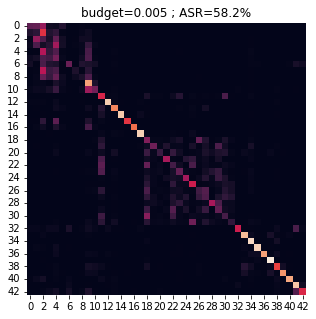

In [69]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
sns.heatmap(cf_matrix,cbar=False)#, annot=True, fmt='.2f')
plt.title(f'budget=0.005 ; ASR={(1-acc)*100:.1f}%')
plt.show()

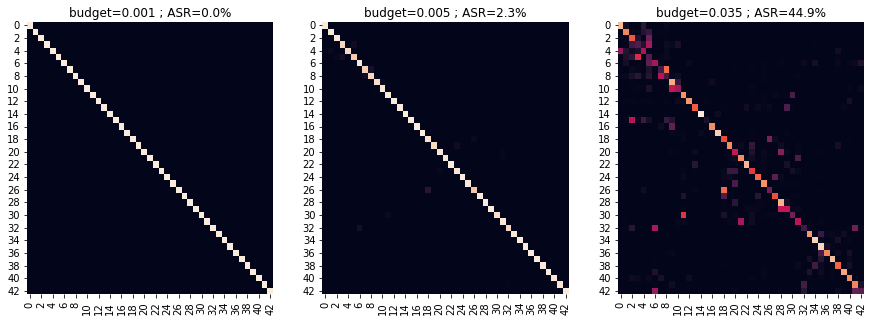

In [30]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
# sns.heatmap(cf_matrix, annot=True, fmt='.2f')
sns.heatmap(cf_matrix_0_001,cbar=False,ax=ax[0])#, annot=True, fmt='.2f')
ax[0].set_title(f'budget=0.001 ; ASR={(1-adv_acc_0_001)*100:.1f}%')
sns.heatmap(cf_matrix_0_005,cbar=False,ax=ax[1])#, annot=True, fmt='.2f')
ax[1].set_title(f'budget=0.005 ; ASR={(1-adv_acc_0_005)*100:.1f}%')
sns.heatmap(cf_matrix_0_035,cbar=False,ax=ax[2])#, annot=True, fmt='.2f')
ax[2].set_title(f'budget=0.035 ; ASR={(1-adv_acc_0_035)*100:.1f}%')
plt.show()